In [199]:
import numpy as np
import matplotlib.pyplot as plt
from aotools.turbulence import phasescreen
from scipy.special import laguerre
from aotools import opticalpropagation
from aotools.turbulence.phasescreen import ft_phase_screen as ps
from aotools.turbulence.phasescreen import ft_sh_phase_screen as psh
import math
from scipy.special import assoc_laguerre

In [200]:
"""
r0 (float) – r0 parameter of scrn in metres
N (int) – Size of phase scrn in pxls
delta (float) – size in Metres of each pxl
L0 (float) – Size of outer-scale in metres
l0 (float) – inner scale in metres
"""
r0 = 1
N = 512
delta = 1e-3
L0 = 1
l0 = 1e-5

In [201]:
D = delta * N  # size of the phasescreen

In [202]:
def plot_field_both(E, extend=None):
	fig, ax = plt.subplots(1, 2, figsize=(13, 6))
	im0 = ax[0].imshow(np.abs(E), extent=extend, cmap='magma')
	ax[0].set_title('|Amplitude|')
	fig.colorbar(im0, ax=ax[0], label='Amplitude', fraction=0.04, pad=0.02)

	im1 = ax[1].imshow(np.angle(E), extent=extend, cmap='hsv')
	ax[1].set_title('Phase')
	fig.colorbar(im1, ax=ax[1], label='Phase (radians)', fraction=0.04, pad=0.02)
	plt.tight_layout()
	plt.show()


def plot_field(E, extend=None):
	fig, ax = plt.subplots(1, 1, figsize=(7, 6))
	im0 = ax.imshow(E, extent=extend, cmap='jet')
	ax.set_title('Value')
	fig.colorbar(im0, ax=ax, label='Amplitude', fraction=0.04, pad=0.02)
	plt.tight_layout()
	plt.show()

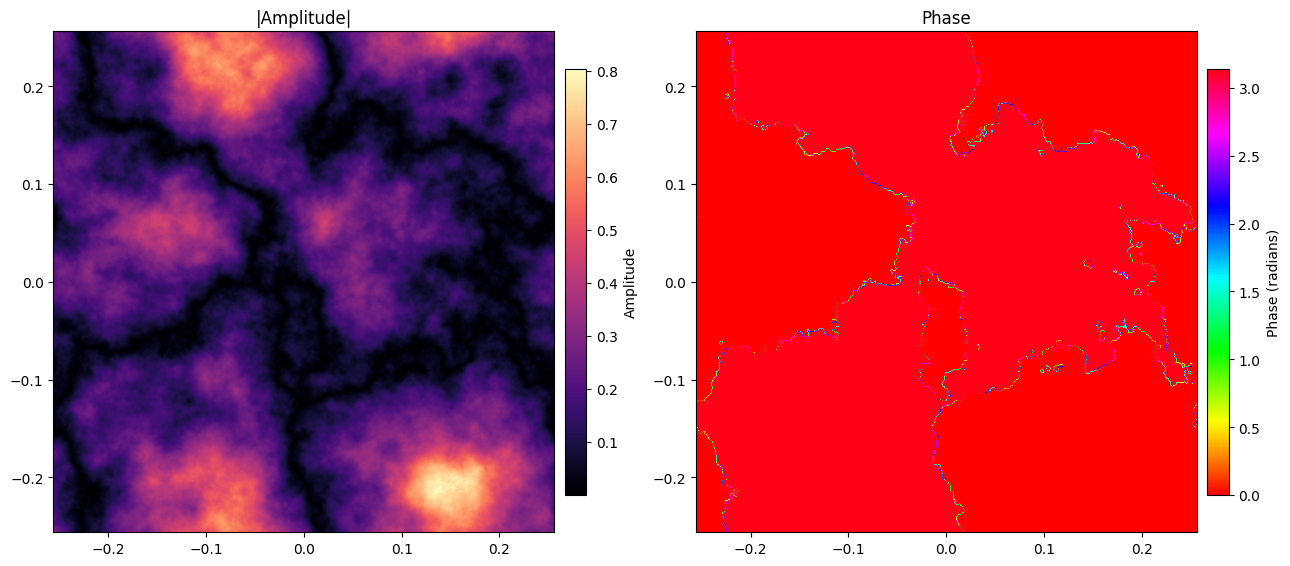

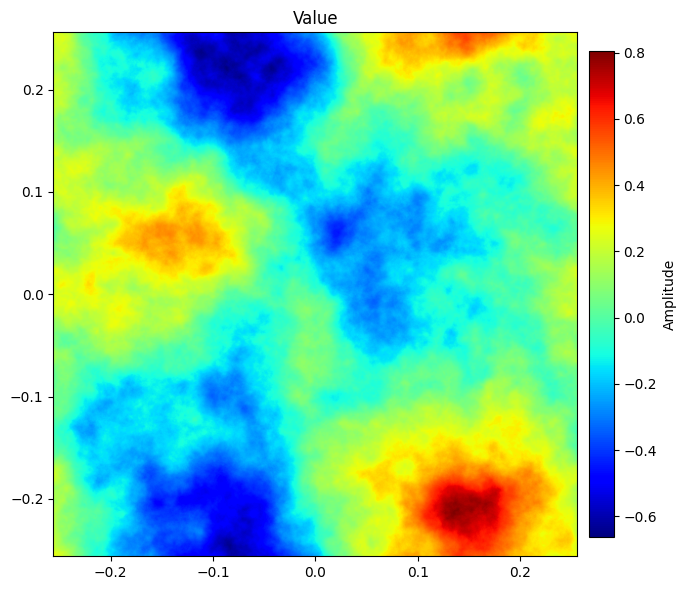

In [203]:
extend = [-D / 2, D / 2, -D / 2, D / 2]
ps_test = ps(r0, N, delta, L0, l0, FFT=None, seed=None)
# print(ps_test)
plot_field_both(ps_test, extend)
plot_field(ps_test, extend)


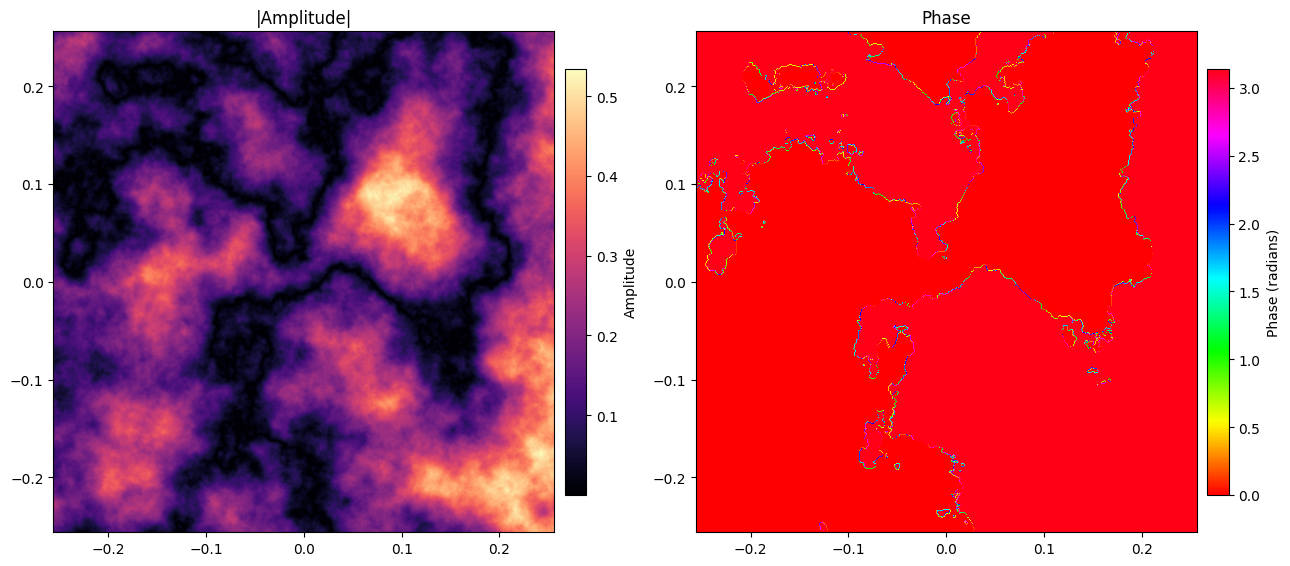

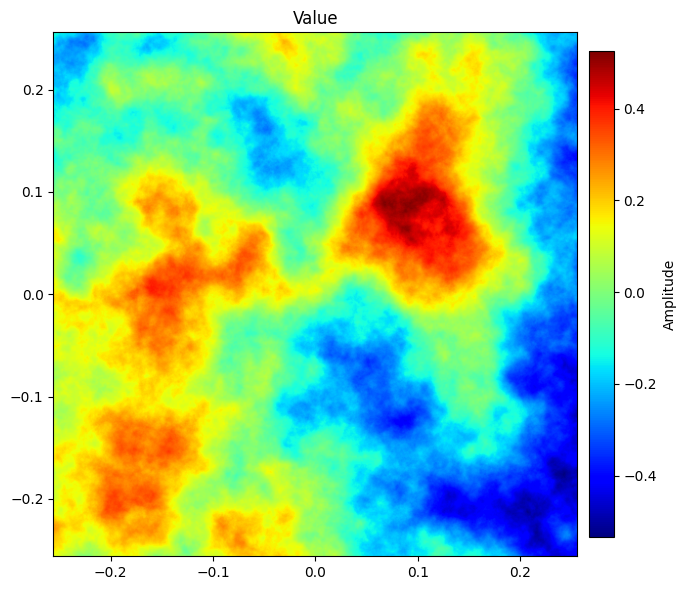

In [204]:
psh_test = psh(r0, N, delta, L0, l0, FFT=None, seed=None)
plot_field_both(psh_test, extend)
plot_field(psh_test, extend)

In [205]:
# def laguerre_gaussian(r, theta, z, l, p, w0, k, wavelength):
#     """
#     Compute the electric field of an LG beam.
#
#     Parameters:
#     - r, theta: Radial and azimuthal coordinates
#     - z: Propagation distance
#     - l, p: LG beam indices
#     - w0: Beam waist
#     - k: Wavenumber
#
#     Returns:
#     - Electric field of the LG beam
#     """
#     # Beam width as a function of z
#     w = w0 * np.sqrt(1 + (z * wavelength / (np.pi * w0 ** 2)) ** 2)
#
#     # Radius of curvature
#     if z == 0:
#         R = np.inf
#     else:
#         R = z * (1 + (np.pi * w0 ** 2 / (z * wavelength)) ** 2)
#
#     # Gouy phase shift
#     zeta = np.arctan(z * wavelength / (np.pi * w0 ** 2))
#
#     # Compute the field
#     L = laguerre(p)
#     amplitude = (np.sqrt(2) * r / w) ** l * np.exp(-r ** 2 / w ** 2) * L(2 * r ** 2 / w ** 2)
#     phase = l * theta - k * r ** 2 / (2 * R) + (2 * p + np.abs(l) + 1) * zeta
#
#     return amplitude * np.exp(1j * phase)
def LG_simple(x, y, z=0, l=1, p=0, width=1, k0=1, x0=0, y0=0, z0=0):
	"""
    Classic LG beam
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :param l: azimuthal index
    :param p: radial index
    :param width: beam waste
    :param k0: wave number
    :param x0: center of the beam in x
    :param y0: center of the beam in y
    :param z0: center of the beam in z
    :return: complex field
    """

	def rho(*r):
		return np.sqrt(sum(x ** 2 for x in r))

	def phi(x, y):
		return np.angle(x + 1j * y)

	def laguerre_polynomial(x, l, p):
		return assoc_laguerre(x, p, l)

	x = x - x0
	y = y - y0
	z = z - z0
	zR = (k0 * width ** 2)
	# zR = (k0 * width ** 2) / 2

	E = (np.sqrt(math.factorial(p) / (np.pi * math.factorial(np.abs(l) + p)))
	     * rho(x, y) ** np.abs(l) * np.exp(1j * l * phi(x, y))
	     / (width ** (np.abs(l) + 1) * (1 + 1j * z / zR) ** (np.abs(l) + 1))
	     * ((1 - 1j * z / zR) / (1 + 1j * z / zR)) ** p
	     * np.exp(-rho(x, y) ** 2 / (2 * width ** 2 * (1 + 1j * z / zR)))
	     * laguerre_polynomial(rho(x, y) ** 2 / (width ** 2 * (1 + z ** 2 / zR ** 2)), np.abs(l), p)
	     )

	return E

In [206]:
xy_lim_2D = (-8.0e-6, 8.0e-6)
res_xy_2D = 150
xy_2D = np.linspace(*xy_lim_2D, res_xy_2D)
mesh_2D = np.meshgrid(xy_2D, xy_2D, indexing='ij')
pxl_xy_scale_start = (xy_lim_2D[1] - xy_lim_2D[0]) / (res_xy_2D - 1)


dx=1.0738255033557047e-07, perfect=4.402147913235084e-07


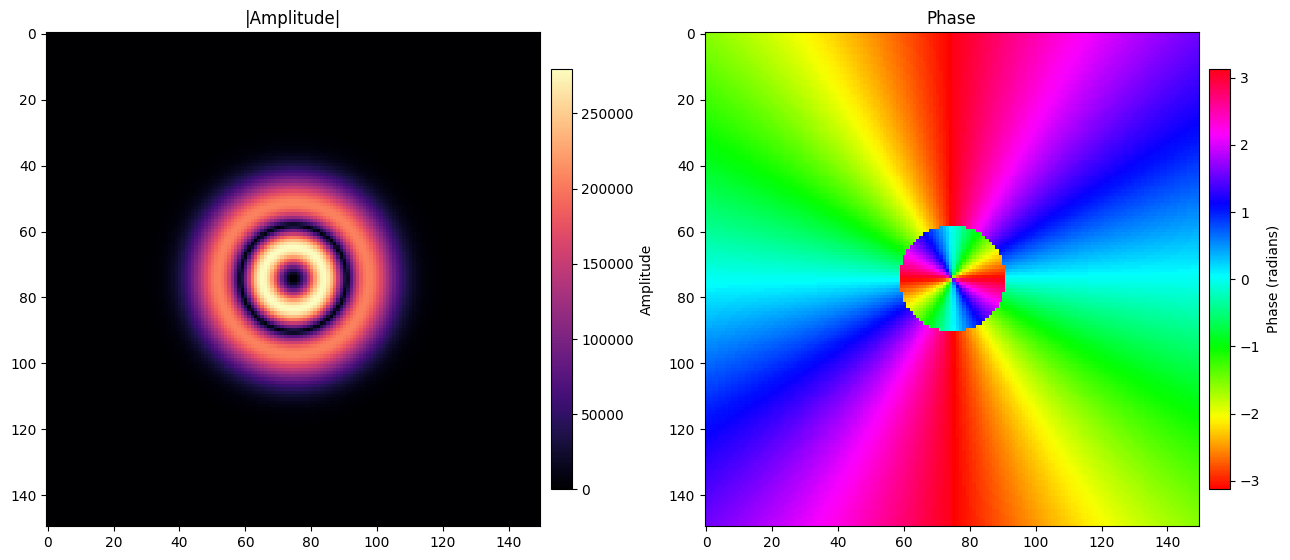

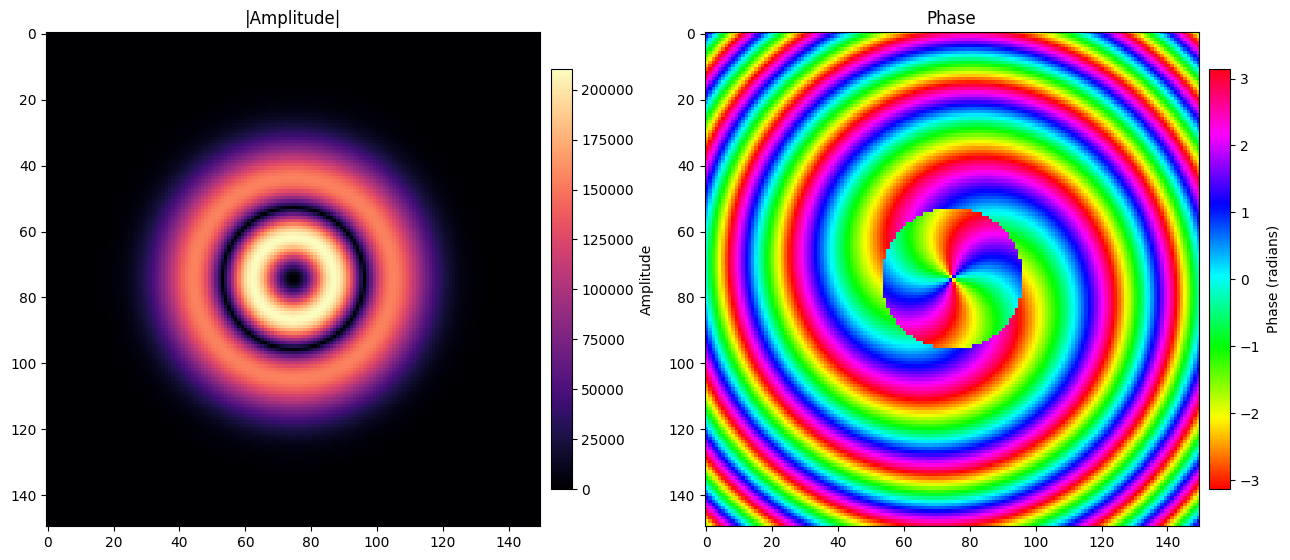

In [207]:
lmbda = 550e-9
width0 = 1e-6
z_pos = 1e-5

k0 = 2 * np.pi / lmbda

LG_21_2D = LG_simple(*mesh_2D, z=0, l=2, p=1, width=width0, k0=k0, x0=0, y0=0, z0=0)
LG_21_2D_z01 = LG_simple(*mesh_2D, z=z_pos, l=2, p=1, width=width0, k0=k0, x0=0, y0=0, z0=0)
D_window = (xy_lim_2D[1] - xy_lim_2D[0])
perfect_scale = lmbda * np.sqrt(z_pos ** 2 + (D_window / 2) ** 2) / D_window
print(f'dx={pxl_xy_scale_start}, perfect={perfect_scale}')
plot_field_both(LG_21_2D, extend=None)
plot_field_both(LG_21_2D_z01, extend=None)

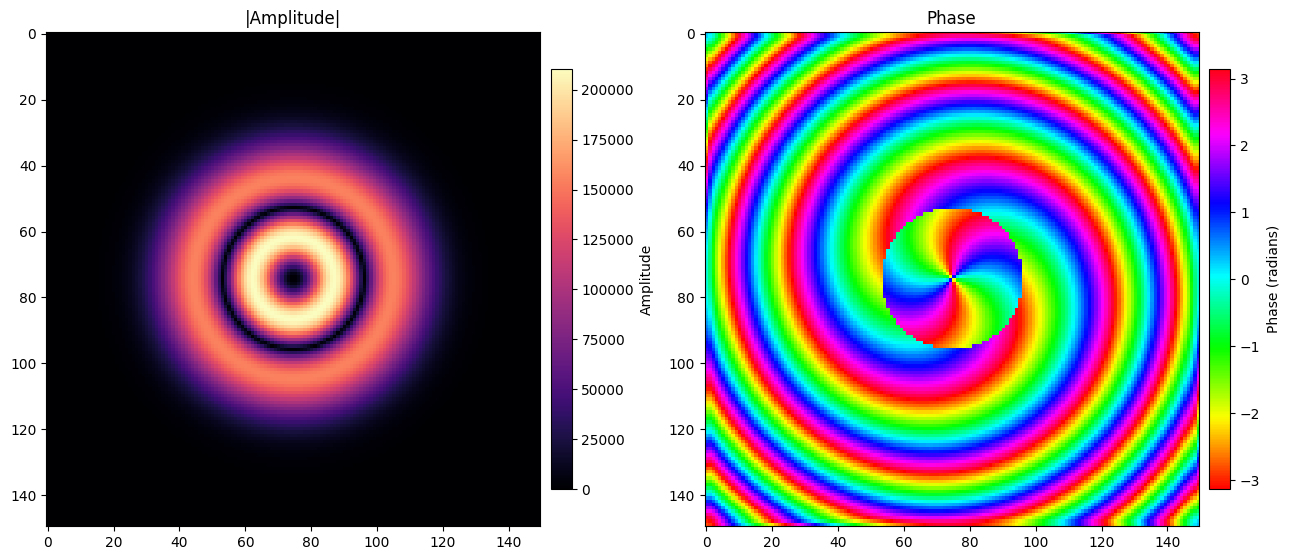

In [208]:
E = LG_21_2D  # * np.exp(1j * ps_test)
pxl_xy_scale_finish = pxl_xy_scale_start
prop_dist = z_pos
E_current = opticalpropagation.angularSpectrum(E, lmbda, pxl_xy_scale_start, pxl_xy_scale_finish, prop_dist)
plot_field_both(E_current, extend=None)

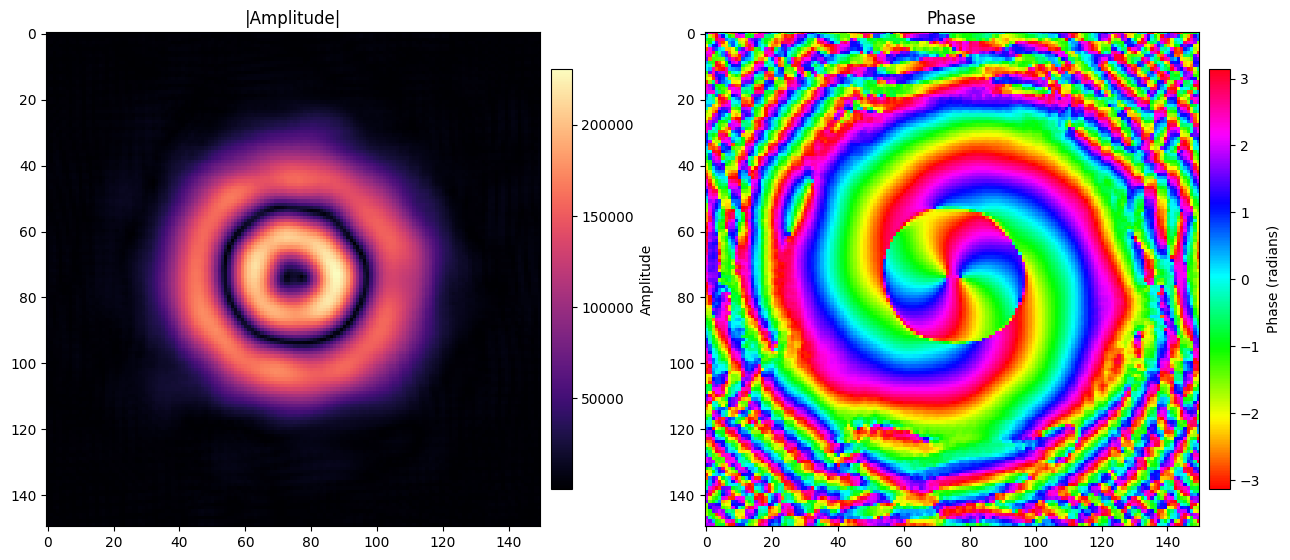

In [209]:
"""
r0 (float) – fried parameter(metres)
N (int) – Size of phase scrn in pxls
delta (float) – size in Metres of each pxl
L0 (float) – Size of outer-scale in metres
l0 (float) – inner scale in metres
"""
r0 = 1e-5
N = res_xy_2D
delta = pxl_xy_scale_start
L0 = 1
l0 = 3e-7
seed = 1
psh_test = psh(r0, N, delta, L0, l0, FFT=None, seed=seed)
prop_dist = z_pos
pxl_xy_scale_finish = pxl_xy_scale_start * 1
E_current = opticalpropagation.angularSpectrum(
	E * np.exp(1j * psh_test), lmbda, pxl_xy_scale_finish, pxl_xy_scale_finish, prop_dist
)
plot_field_both(E_current, extend=None)

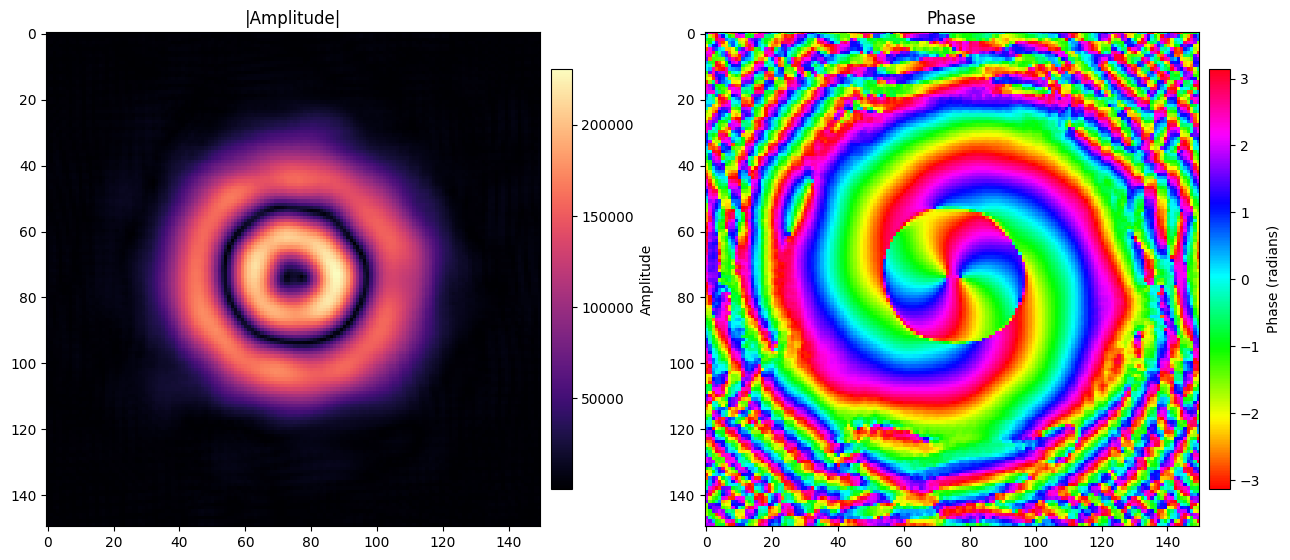

In [229]:
r0 = 1e-5
N = res_xy_2D
delta = pxl_xy_scale_start
L0 = 1
l0 = 3e-7
seed = 1
psh_test = psh(r0, N, delta, L0, l0, FFT=None, seed=seed)
prop_dist = z_pos
pxl_xy_scale_finish = pxl_xy_scale_start * 1
E_current = opticalpropagation.angularSpectrum(
	E * np.exp(1j * psh_test), lmbda, pxl_xy_scale_finish, pxl_xy_scale_finish, prop_dist
)
plot_field_both(E_current, extend=None)

In [230]:
def r0_from_Cn2(Cn2, k0, dz):
	return (0.423 * k0 ** 2 * Cn2 * dz) ** (-3 / 5)


def Cn2_from_r0(r0, k0, dz):
	return r0 ** (-5 / 3) / (0.423 * k0 ** 2 * dz)


def SR_from_r0(r0, D):
	return np.exp(-(D / r0) ** (5 / 3))

def SR_from_Cn2(Cn2, k0, dz, D):
	r0 = r0_from_Cn2(Cn2, k0, dz)
	return np.exp(-(D / r0) ** (5 / 3))

def rytov(Cn2, k0, dz):
	return 1.23 * Cn2 * k0 ** (7/6) * dz ** (11/6)

def screens_number(Cn2, k0, dz):
	sigma_rytov = rytov(Cn2, k0, dz)
	return (10 * sigma_rytov) ** (6/11)
	# return math.ceil((10 * sigma_rytov) ** (6/11))

In [212]:
Cn2_1, Cn2_2 = 1e-13, 1e-15
dz = 25
r0_1, r0_2 = r0_from_Cn2(Cn2_1, k0, dz), r0_from_Cn2(Cn2_2, k0, dz)

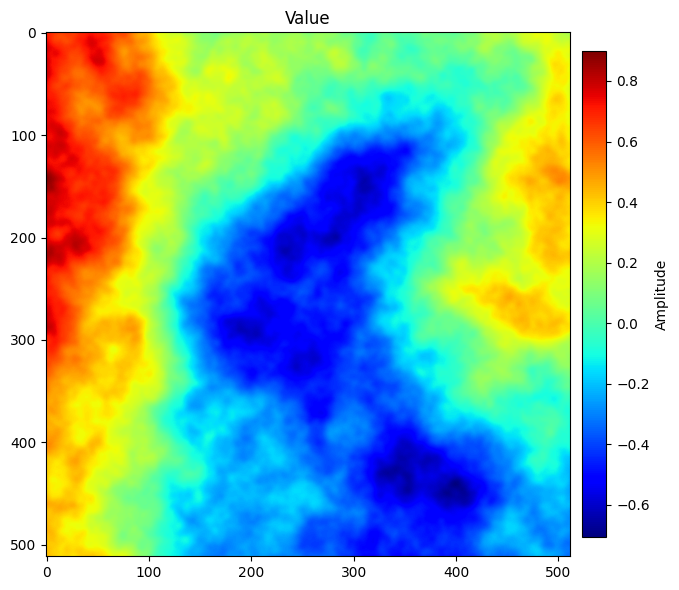

In [213]:
psh1 = psh(r0_2, 512, 0.001, L0=10, l0=0.01, FFT=None)
plot_field(psh1)

In [214]:
# Real SR value

In [215]:
print(xy_2D)
print(pxl_xy_scale_start / 2)

[-8.00000000e-06 -7.89261745e-06 -7.78523490e-06 -7.67785235e-06
 -7.57046980e-06 -7.46308725e-06 -7.35570470e-06 -7.24832215e-06
 -7.14093960e-06 -7.03355705e-06 -6.92617450e-06 -6.81879195e-06
 -6.71140940e-06 -6.60402685e-06 -6.49664430e-06 -6.38926174e-06
 -6.28187919e-06 -6.17449664e-06 -6.06711409e-06 -5.95973154e-06
 -5.85234899e-06 -5.74496644e-06 -5.63758389e-06 -5.53020134e-06
 -5.42281879e-06 -5.31543624e-06 -5.20805369e-06 -5.10067114e-06
 -4.99328859e-06 -4.88590604e-06 -4.77852349e-06 -4.67114094e-06
 -4.56375839e-06 -4.45637584e-06 -4.34899329e-06 -4.24161074e-06
 -4.13422819e-06 -4.02684564e-06 -3.91946309e-06 -3.81208054e-06
 -3.70469799e-06 -3.59731544e-06 -3.48993289e-06 -3.38255034e-06
 -3.27516779e-06 -3.16778523e-06 -3.06040268e-06 -2.95302013e-06
 -2.84563758e-06 -2.73825503e-06 -2.63087248e-06 -2.52348993e-06
 -2.41610738e-06 -2.30872483e-06 -2.20134228e-06 -2.09395973e-06
 -1.98657718e-06 -1.87919463e-06 -1.77181208e-06 -1.66442953e-06
 -1.55704698e-06 -1.44966

In [216]:
def arrays_from_mesh(mesh, indexing='ij'):
	"""
	Functions returns the tuple of x1Array, x2Array... of the mesh
	:param indexing: ij for a classic matrix
	:param mesh: no-sparse mesh, for 3D: [3][Nx, Ny, Nz]
	:return: for 3D: xArray, yArray, zArray
	"""
	xList = []
	if indexing == 'ij':
		for i, m in enumerate(mesh):
			row = [0] * len(np.shape(m))
			row[i] = slice(None, None)
			xList.append(m[tuple(row)])
	else:
		if len(np.shape(mesh[0])) == 2:
			for i, m in enumerate(mesh):
				row = [0] * len(np.shape(m))
				row[len(np.shape(m)) - 1 - i] = slice(None, None)
				xList.append(m[tuple(row)])
		elif len(np.shape(mesh[0])) == 3:
			indexing = [1, 0, 2]
			for i, m in enumerate(mesh):
				row = [0] * len(np.shape(m))
				row[indexing[i]] = slice(None, None)
				xList.append(m[tuple(row)])
		else:
			print("'xy' cannot be recreated for 4+ dimensions")

	xTuple = tuple(xList)
	return xTuple

def SR_gauss(mesh_2D, L, beam_par, psh_par, epochs=100):
	l, p, width0, k0 = beam_par
	r0, N, delta, L0, l0 = psh_par
	xy_array, _ = arrays_from_mesh(mesh_2D)
	xy_scale = xy_array[1] - xy_array[0]
	assert N == len(xy_array), 'Resolution of the beam isn"t equal to the phase screen N'
	assert len(xy_array) % 2 == 0, 'Odd resolution of the beam'
	LG_00 = LG_simple(*mesh_2D, z=0, l=l, p=p, width=width0, k0=k0, x0=0, y0=0, z0=0)
	I0 = np.abs(LG_simple(x=xy_scale / 2, y=xy_scale / 2, z=L,
						  l=l, p=p, width=width0, k0=k0, x0=0, y0=0, z0=0)) ** 2
	I_avg_tot = 0
	for i in range(epochs):
		psh_test = psh(r0, N, delta, L0, l0, FFT=None)
		E_current = opticalpropagation.angularSpectrum(
			LG_00 * np.exp(1j * psh_test), lmbda, pxl_xy_scale_finish, pxl_xy_scale_finish, prop_dist
		)
		I_avg_tot += np.abs(E_current[res_xy_2D // 2, res_xy_2D // 2]) ** 2
		# if i == 1:
		# 	plot_field_both(E_current, extend=None)
	I_avg = I_avg_tot / epochs
	SR = I_avg / I0
	print(f'SR={SR}')
	return SR

beam_par = (0, 0, width0, k0)
psh_par = (r0, N, delta, L0, l0)
L = 1e-5
SR_gauss(mesh_2D, L, beam_par, psh_par, epochs=500)

SR=0.9202975472468583


0.9202975472468583

In [232]:
D = N * delta / 7
D = 0.23 * r0
Cn2 = Cn2_from_r0(r0, k0, dz=L)
SR_r0 = SR_from_r0(r0, D)
SR_Cn2 = SR_from_Cn2(Cn2, k0, L, D)
print(SR_r0, SR_Cn2)

0.9172821169870715 0.9172821169870715


In [231]:
screens_number(Cn2, k0, dz=L)

0.7293510244085597

In [ ]:
Cn2_real_array = [1e-17, 1e-16, 1e-15, 1e-14, 1e-13]  # strong -> weak
r0_from_Cn2(Cn2, k0, dz)